<a href="https://colab.research.google.com/github/peter1250/study/blob/main/%EA%B0%84%EB%8B%A8%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:

import pandas as pd
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
CFG = {
    'IMG_SIZE':128, 
    'EPOCHS':50, 
    'LEARNING_RATE':2e-2, 
    'BATCH_SIZE':12, 
    'SEED':41, 
}

In [18]:
data = pd.read_csv('train.csv')
df = data.drop(['index'],axis=1)

In [84]:
label = df['label']
from sklearn.preprocessing import LabelEncoder

le  =LabelEncoder()
le.fit(label)

label_ec = le.transform(label)
label_ec 

88

In [41]:
encdf = pd.DataFrame(label_ec,columns = ['encode'])
le_df = pd.concat([df,encdf],axis=1)

In [ ]:
%cd data
# !unzip --q "/content/drive/MyDrive/dataset/train data.zip"
!unzip --q "/content/drive/MyDrive/dataset/test.zip"

In [50]:
file_df = le_df[['file_name','encode']]

In [54]:

fdf = file_df.rename(columns={'encode':'label'})

In [57]:
from glob import glob
import os

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(fdf['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    
    return img_path_list

In [96]:
all_img_path, all_label = get_train_data('/content/data/train data')
test_img_path = get_test_data('/content/data/test')

In [97]:
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): 
        img_path = self.img_path_list[index]

        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): 
        return len(self.img_path_list)

In [98]:

train_len = int(len(all_img_path)*0.75)
Vali_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [99]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', Vali_len)

train set 길이 :  2250
vaildation set 길이 :  750


In [100]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), 
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) 
                    
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

In [101]:
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 2250 / total train batches : 188
total valid imgs : 750 / total valid batches : 63


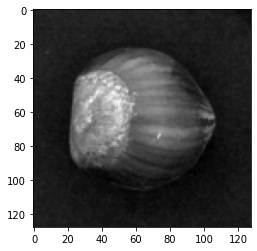

Label: 33


In [102]:
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)). 
img = train_features[0]
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

In [75]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Batch Labels shape: {train_labels}")

Feature batch shape: torch.Size([12, 3, 128, 128])
Batch Labels shape: tensor([76, 28, 18, 28, 15, 63,  9, 55, 40, 21, 84, 55])


In [85]:
from tqdm.auto import tqdm
import torch.nn as nn 

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)) 
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)) 
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)) 
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(3136, 88)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x)
        
        x = self.layer2(x)
         
        x = self.layer3(x)
        
        x = self.layer4(x) 
        
        x = torch.flatten(x, start_dim=1) 
        
        out = self.fc_layer(x)
        return out

In [86]:
import torch.optim as optim 

model = CNNclassification().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

In [89]:
def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    criterion = nn.CrossEntropyLoss().to(device)
    best_acc = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1): 
        model.train() 
        running_loss = 0.0
            
        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()

            logit = model(img)
            loss = criterion(logit, label) 

            loss.backward()
            optimizer.step() 
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            

        model.eval() 
        vali_loss = 0.0
        correct = 0
        with torch.no_grad():
            for img, label in tqdm(iter(vali_loader)):
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True) 
                correct += pred.eq(label.view_as(pred)).sum().item()
        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))
        
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), 'best_model.pth') 
            print('Model Saved.')

In [ ]:
train(model, optimizer, train_loader, scheduler, device)

In [103]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [104]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/data/best_model.pth')
model = CNNclassification().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

  0%|          | 0/84 [00:00<?, ?it/s]

[68, 40, 33, 33, 55]

In [106]:
answer = le.inverse_transform(preds)

In [110]:
submission = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')
submission['label'] = answer

In [127]:
label_split = df['label'].str.split("-")
submission["class"] = label_split.str.get(0)
submission["state"] = label_split.str.get(1)

In [130]:
submit = submission[['file_name','class','state','label']]

In [132]:
submit.to_csv('submit.csv', index=False)